In [20]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms, datasets
import os 
import matplotlib.pyplot as plt

In [2]:
# Hyperparameters
num_epochs = 5
num_classes = 10
batch_size = 100
learning_rate = 0.001

current_dir = os.getcwd()

DATA_PATH = current_dir
MODEL_STORE_PATH = current_dir
trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST dataset
train_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=True, transform=trans, download=True)
test_dataset = torchvision.datasets.MNIST(root=DATA_PATH, train=False, transform=trans)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [3]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        self.fc2 = nn.Linear(1000, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.reshape(out.size(0), -1)
        out = self.drop_out(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [4]:
model = ConvNet()

# Loss and Adam optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [7]:
# Train the model
total_step = len(train_loader)
loss_list = []
acc_list = []
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Run the forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track the accuracy
        total = labels.size(0)
        _, predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        acc_list.append(correct / total)

        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}%'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(),
                          (correct / total) * 100))

Epoch [1/5], Step [100/600], Loss: 0.1336, Accuracy: 96.00%
Epoch [1/5], Step [200/600], Loss: 0.1172, Accuracy: 96.00%
Epoch [1/5], Step [300/600], Loss: 0.0159, Accuracy: 100.00%
Epoch [1/5], Step [400/600], Loss: 0.0873, Accuracy: 96.00%
Epoch [1/5], Step [500/600], Loss: 0.0827, Accuracy: 95.00%
Epoch [1/5], Step [600/600], Loss: 0.1011, Accuracy: 97.00%
Epoch [2/5], Step [100/600], Loss: 0.0203, Accuracy: 99.00%
Epoch [2/5], Step [200/600], Loss: 0.0491, Accuracy: 98.00%
Epoch [2/5], Step [300/600], Loss: 0.0400, Accuracy: 99.00%
Epoch [2/5], Step [400/600], Loss: 0.0461, Accuracy: 98.00%
Epoch [2/5], Step [500/600], Loss: 0.0133, Accuracy: 99.00%
Epoch [2/5], Step [600/600], Loss: 0.0214, Accuracy: 99.00%
Epoch [3/5], Step [100/600], Loss: 0.0764, Accuracy: 98.00%
Epoch [3/5], Step [200/600], Loss: 0.0276, Accuracy: 99.00%
Epoch [3/5], Step [300/600], Loss: 0.0129, Accuracy: 99.00%
Epoch [3/5], Step [400/600], Loss: 0.0874, Accuracy: 96.00%
Epoch [3/5], Step [500/600], Loss: 0.02

In [9]:
# Test the model
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Test Accuracy of the model on the 10000 test images: {} %'.format((correct / total) * 100))

# Save the model and plot
torch.save(model.state_dict(), MODEL_STORE_PATH + '/conv_net_model.ckpt')

Test Accuracy of the model on the 10000 test images: 98.97 %


In [55]:
dataiter = iter(test_loader)
images, labels = dataiter.next()


tensor(4)


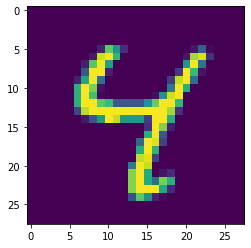

In [65]:
imgidx = 6
img = images[imgidx][0]
plt.imshow(img)
output = model(images)
print(torch.max(output.data,1)[1][imgidx])

In [51]:
images[0][0][3]

tensor([-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
        -0.4242, -0.4242, -0.4242, -0.4242])